In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import os
import shutil
import random
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import cv2
from sklearn.utils import shuffle
from random import randint
from IPython.display import SVG

## DATA AUGMENTATION

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm
datagen = ImageDataGenerator(
        fill_mode = "constant",
        rotation_range=5,
        shear_range=0.05,
        width_shift_range=0.01,
        zoom_range=0.1,
        height_shift_range=0.01,
        vertical_flip=True,
        horizontal_flip=True)
classes = ['tennis_court','swimming_pool','runway','railway','overpass','oil_well','golf_course','crosswalk', 'bridge', 'basketball_court']

In [ ]:
for cls in classes:
    for filename in tqdm(os.listdir("/content/drive/My Drive/GNR/dataset/train/"+cls)):
        img = load_img("/content/drive/My Drive/GNR/dataset/train/"+cls+"/"+filename)  # PIL image
        x = img_to_array(img)  # Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 3, 150, 150)

        i = 0
        for batch in datagen.flow(x, batch_size=1,
                              save_to_dir="/content/drive/My Drive/GNR/dataset/train_new/train/"+cls, save_prefix=filename, save_format='jpeg'):
            i += 1
            if i > 11:
                break  # to stop the generator from looping infinitely

100%|██████████| 50/50 [00:08<00:00,  5.57it/s]


## Making different Validation set randomly

In [ ]:
#  Making different folders for Train and Val having random elements based on split ratio

root_dir = "/content/drive/My Drive/GNR/dataset/train"
classes_dir = ['tennis_court','swimming_pool','runway','railway','overpass','oil_well','golf_course','crosswalk', 'bridge', 'basketball_court']

val_ratio = 0.20 # split ratio

for cls in classes_dir:
    os.makedirs(root_dir +'/train/' + cls)
    os.makedirs(root_dir +'/val/' + cls)

    # Creating partitions of the data after shuffeling
    src = root_dir + "/" + cls # To copy images from this folder loc

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames= np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - val_ratio))])

# We dont need this train folder becauz we will use augumented train_new data

    # train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    # print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))

# Copy-pasting images
    # for name in train_FileNames:
    #     shutil.copy(name, root_dir +'/train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/val/' + cls)


## Defining labels for given data

In [ ]:
def get_images(directory):
    Images = []
    Labels = []  
    for labels in os.listdir(directory):
        if os.path.isdir(directory+labels):
            if labels == 'basketball_court': 
                label = 0
            elif labels == 'bridge':
                label = 1
            elif labels == 'crosswalk':
                label = 2
            elif labels == 'golf_course':
                label = 3
            elif labels == 'oil_well':
                label = 4
            elif labels == 'overpass':
                label = 5
            elif labels == 'railway':
                label = 6
            elif labels == 'runway':
                label = 7
            elif labels == 'swimming_pool':
                label = 8
            elif labels == 'tennis_court':
                label = 9

            for image_file in os.listdir(directory+labels): 
                image = cv2.imread(directory+labels+'/'+image_file)
                image = cv2.resize(image,(256,256)) 
                Images.append(image)
                Labels.append(label)
        
        else:

            for image_file in os.listdir(directory): 
                image = cv2.imread(directory+'/'+image_file) 
                image = cv2.resize(image,(256,256)) 
                Images.append(image)

    return Images,Labels

def get_classlabel(class_code):
    labels = {0:'basketball_court', 1:'bridge', 2:'crosswalk', 3:'golf_course', 4:'oil_well', 5:'overpass', 6:'railway',7:'runway',8:'swimming_pool',9:'tennis_court'}
    return labels[class_code]


### Assigning labels to augmented train dataset

In [ ]:
Images, Labels = get_images('/content/drive/MyDrive/GNR/dataset/train_new/train/') 

Images = np.array(Images) 
Labels = np.array(Labels)
c = list(zip(Images, Labels))  
random.shuffle(c)          #doing random shuffling of images and labels (maintaining their order)
Images, Labels = zip(*c)
Images = np.array(Images) 
Labels = np.array(Labels)

print("Shape of Images array is:",Images.shape)
print("Shape of Labels array is:",Labels.shape)

Shape of Images array is: (5995, 256, 256, 3)
Shape of Labels array is: (5995,)


In [ ]:
# just testing before implementing

# a = ['a', 'b', 'c','x','y','z']
# b = [1, 2, 3,9,7,8]

# c = list(zip(a, b))

# random.shuffle(c)

# a, b = zip(*c)

# print(a)
# print(b)


### Assigning labels to augmented validation dataset

In [ ]:
Images1, Labels1 = get_images('/content/drive/MyDrive/GNR/dataset/train/val/') 

Images1 = np.array(Images1) 
Labels1 = np.array(Labels1)

c = list(zip(Images1, Labels1))
random.shuffle(c)           #doing random shuffling of images and labels (maintaining their order)
Images1, Labels1 = zip(*c)
Images1 = np.array(Images1) 
Labels1 = np.array(Labels1)

print("Shape of Images array is:",Images1.shape)
print("Shape of Labels array is:",Labels1.shape)

Shape of Images array is: (100, 256, 256, 3)
Shape of Labels array is: (100,)


In [ ]:
# loading data in respective variables 

x_train,y_train=Images,Labels 
x_val,y_val=Images1,Labels1

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)


In [ ]:
# np.shape(y_val)

# CNN MODEL

In [ ]:
from tensorflow.keras.layers import Dense, Input, SpatialDropout2D,Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, LeakyReLU

def cnnmodel():
    model = Models.Sequential()

    # 1st Convolutional Layer
    model.add(Layers.Conv2D(filters=32, input_shape=(256,256,3), kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(SpatialDropout2D(0.5))
    
    # 2nd Convolutional Layer
    model.add(Layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(SpatialDropout2D(0.4))
    # model.add(Layers.Dropout(0.1))

    # 3rd Convolutional Layer
    model.add(Layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(SpatialDropout2D(0.3))
    # model.add(Layers.Dropout(0.1))

    # 4th Convolutional Layer
    model.add(Layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3), padding='valid'))
    model.add(SpatialDropout2D(0.2))
    # model.add(Layers.Dropout(0.25))

    # 5th Convolutional Layer
    model.add(Layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3), padding='valid'))
    model.add(SpatialDropout2D(0.1))
    # model.add(Layers.Dropout(0.25))

    model.add(Layers.Flatten())

    # 1st Fully Connected Layer
    model.add(Layers.Dense(512,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.6))

    # 2nd Fully Connected Layer
    model.add(Layers.Dense(128,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.6))

    # Add output layer
    model.add(Layers.Dense(10,kernel_initializer='he_uniform',activation="softmax"))
    return model


model1 = cnnmodel()
model1.summary()
SVG(model_to_dot(model1).create(prog='dot', format='svg'))
Utils.plot_model(model1,to_file='model.png',show_shapes=True)

model1.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

batch_size = 64

red_lr= ReduceLROnPlateau(monitor='val_loss',patience=4,verbose=1,factor=0.3, mode='auto', min_lr=10**(-12))
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

epochs = 15

history = model1.fit(datagen.flow(x_train,y_train, batch_size=batch_size), epochs=epochs, 
                        validation_data = (x_val,y_val),verbose = 1,
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        callbacks=[red_lr, mcp_save])

Epoch 1/15
93/93 [==============================] - 126s 999ms/step - loss: 1.9774 - accuracy: 0.3411 - val_loss: 5.7359 - val_accuracy: 0.2700
Epoch 2/15
93/93 [==============================] - 91s 970ms/step - loss: 1.2839 - accuracy: 0.5524 - val_loss: 1.4711 - val_accuracy: 0.5100
Epoch 3/15
93/93 [==============================] - 90s 969ms/step - loss: 0.9268 - accuracy: 0.6822 - val_loss: 0.7478 - val_accuracy: 0.6600
Epoch 4/15
93/93 [==============================] - 90s 970ms/step - loss: 0.6598 - accuracy: 0.7813 - val_loss: 0.8305 - val_accuracy: 0.6300
Epoch 5/15
93/93 [==============================] - 90s 969ms/step - loss: 0.5210 - accuracy: 0.8245 - val_loss: 0.2158 - val_accuracy: 0.9400
Epoch 6/15
93/93 [==============================] - 91s 975ms/step - loss: 0.4330 - accuracy: 0.8601 - val_loss: 0.2579 - val_accuracy: 0.8900
Epoch 7/15
93/93 [==============================] - 91s 974ms/step - loss: 0.3718 - accuracy: 0.8769 - val_loss: 0.1048 - val_accuracy: 0.990

## Plotting Loss and Accuracy curves for both datasets

Text(0.5, 1.0, 'Accuracy Curves')

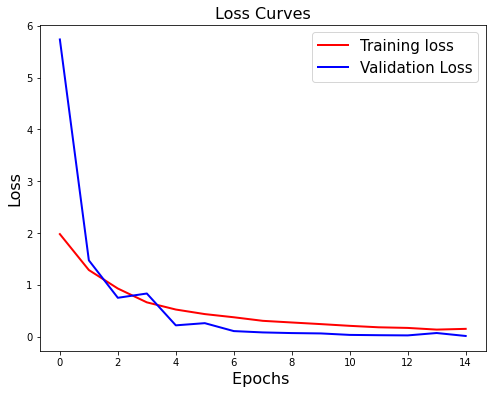

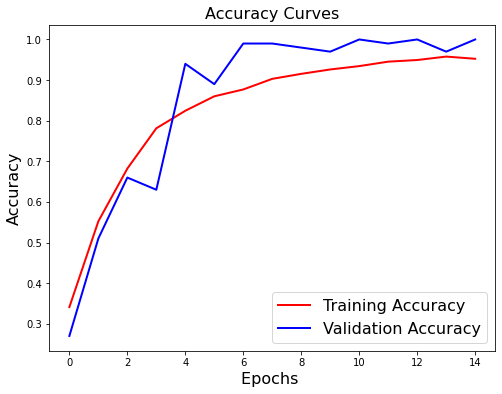

In [ ]:
# plotting loss curves for both train and val dataset

plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=15)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# plotting accuracy curves for both train and val dataset

plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

As the validation loss saturates, so I stopped at epoch=15

## Making predictions on test data

In [ ]:
submission = pd.DataFrame()
i= []
l=[]

for img in os.listdir('/content/drive/MyDrive/GNR/dataset/test/'):
    image = cv2.imread('/content/drive/MyDrive/GNR/dataset/test/'+str(img)) 
    image = cv2.resize(image,(256,256)) 
    # image = cv2.resize(image,(256,256),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
    image = np.reshape(image,[1,256,256,3])
    i.append(img[0:4])
    l.append(np.argmax(model1.predict(image)[0]) +1)  # Time to test our model on test data
    
    
submission['ImageID'] = i
submission['LabelID']= l
    
submission.to_csv('190010009.csv', index=False)